## cc

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community
from master_thesis.hsbmpy import get_file, get_max_available_L

In [33]:
directory = '/home/fvalle/phd/datasets/tcga/oversampling_10tissue/'
L = get_max_available_L(directory)
os.chdir(directory)

In [44]:
for l in range(L+1):
    df_hsbm = pd.read_csv("topsbm/topsbm_level_%d_clusters.csv"%l)
    df_lda = pd.read_csv("lda/lda_level_%d_clusters.csv"%l)
    df_files = pd.read_csv("files.dat", index_col=0)
    G = nx.Graph()
    for c in df_hsbm.columns:
        nodes = [get_file(sample,df_files).name for sample in df_hsbm[c].dropna().values]
        for a, node_a in enumerate(nodes):
            for node_b in nodes[a+1:]:
                if G.has_edge(node_a, node_b):
                    # we added this one before, just increase the weight by one
                    G[node_a][node_b]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(node_a, node_b, weight=1)

    for c in df_lda.columns:
        nodes = [get_file(sample,df_files).name for sample in df_lda[c].dropna().values]
        for a, node_a in enumerate(nodes):
            for node_b in nodes[a+1:]:
                if G.has_edge(node_a, node_b):
                    # we added this one before, just increase the weight by one
                    G[node_a][node_b]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(node_a, node_b, weight=1)
    remove_edge = []
    for edge in G.edges:
        if G.get_edge_data(*edge)['weight']<=1:
            if (G.degree[edge[0]] > 1) and (G.degree[edge[1]] > 1):
                remove_edge.append(edge)
    G.remove_edges_from(remove_edge)
    
    partition = fast_consensus(G, n_p=200, thresh=2,delta=0.01)
    
    parttition_out={}
    for node, c in partition[0].items():
        if c in parttition_out.keys():
            parttition_out[c].append(node)
        else:
            parttition_out[c]=[node]
    M = np.max([len(parttition_out[c]) for c in parttition_out.keys()])
    print("level %d with %d clusters"%(l, np.max([a for a in parttition_out.keys()])))
    df_cc = pd.DataFrame(columns=["Cluster %d"%(c+1) for c in np.arange(np.max([a for a in parttition_out.keys()])+1)])
    for C,c in zip(df_cc.columns, parttition_out.keys()):
        df_cc[C]=np.concatenate([parttition_out[c],['' for _ in range(M-len(parttition_out[c]))]])
    df_cc.to_csv("cc/cc_level_%d_clusters.csv"%l, index=False)

level 0 with 684 clusters
level 1 with 356 clusters
level 2 with 69 clusters
level 3 with 24 clusters
level 4 with 1 clusters


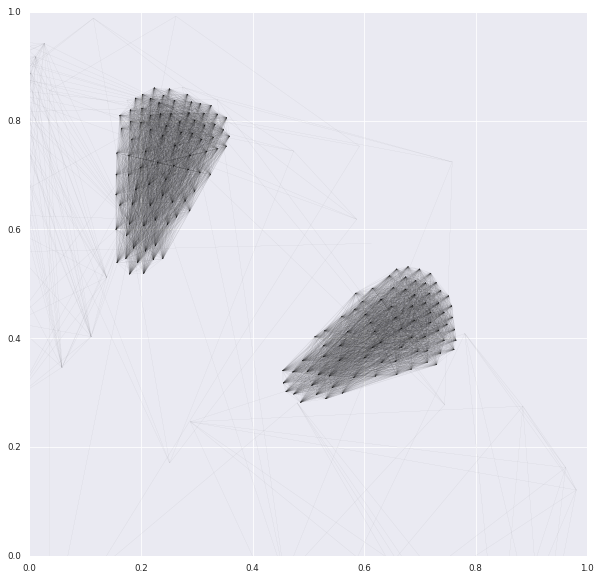

In [21]:
fig=plt.figure(figsize=(10,10))
ax=fig.subplots()
pos=nx.spring_layout(G, k=.5) # positions for all nodes
nx.draw_networkx_edges(G,pos,width=.05,alpha=0.5)
plt.show()